In [2]:
%reload_ext autoreload
%autoreload 2
import os
import sys
import glob
import numpy as np
import scipy as sc
import pandas as pd
import tensorflow as tf

from pyhdf.SD import SD, SDC 
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import patches as mpl_patches
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE as TSNEs

In [52]:
import re

In [50]:
libdir='/home/tkurihana/Research/clouds/src_analysis/lib_hdfs'
sys.path.insert(1,os.path.join(sys.path[0],libdir))
from lib_modis02 import proc_sds
from analysis_lib import _get_colors

### Prep Data

In [4]:
anl_dir='/home/tkurihana/Research/clouds/clustering/output_clustering_2000_2018_m02_band28_29_31/sklearn_agglomerative/18k'

In [29]:
def read_filelist(filename):
    filelist = []
    with open(filename) as f:
        for line in f.readlines():
            lines = line.split('.npz')
            for iline in lines:
                if len(iline) > 0:
                    print(os.path.basename(iline)+'.npz')
                    filelist.append(iline+'.npz')
    return filelist

In [34]:
filelist = os.path.join(anl_dir, 'filelist_metadata_aggl_random-16610.txt')

In [35]:
npz_filelist = read_filelist(filelist)

clouds_patches_2015334.mosa_4.npz
clouds_patches_2015344.mosa_4.npz
clouds_patches_2015348.mosa_3.npz
clouds_patches_2015342.mosa_2.npz
clouds_patches_2015336.mosa_1.npz
clouds_patches_2015320.mosa_0.npz
clouds_patches_2015339.mosa_4.npz
clouds_patches_2015335.mosa_0.npz
clouds_patches_2015324.mosa_4.npz
clouds_patches_2015329.mosa_4.npz
clouds_patches_2015333.mosa_3.npz
clouds_patches_2015340.mosa_0.npz
clouds_patches_2015326.mosa_1.npz
clouds_patches_2015337.mosa_2.npz
clouds_patches_2015349.mosa_4.npz
clouds_patches_2015347.mosa_2.npz
clouds_patches_2015341.mosa_1.npz
clouds_patches_2015346.mosa_1.npz
clouds_patches_2015322.mosa_2.npz
clouds_patches_2015331.mosa_1.npz
clouds_patches_2015323.mosa_3.npz
clouds_patches_2015332.mosa_2.npz
clouds_patches_2015345.mosa_0.npz
clouds_patches_2015328.mosa_3.npz
clouds_patches_2015327.mosa_2.npz
clouds_patches_2015330.mosa_0.npz
clouds_patches_2015343.mosa_3.npz
clouds_patches_2015321.mosa_1.npz
clouds_patches_2015325.mosa_0.npz
clouds_patches

In [40]:
def npz_loader(npz):
    print(npz)
    data_array =  np.load(npz)
    clouds_xy_list = data_array['clouds_xy']
    return clouds_xy_list

In [33]:
def reconst_img(_patches, _patches_labels, _xy_list):
    ix, iy = _patches.shape[:2]
    img_array = np.zeros((ix,iy)).astype(np.float64)
    img_array[:,:] = np.nan
    for idx, (x,y) in enumerate(_xy_list):
        img_array[x,y] = _patches_labels[idx]
    return img_array

In [36]:
nx, ny = 35, 37
n_clusters = 12
patches = np.ones((nx, ny)) * 12 # ncluster = 12

In [42]:
clouds_xy_list = npz_loader(npz_filelist[0])

/home/tkurihana/Research/clouds/clustering/outputs/output_clouds_feature_20151116-20151215/clouds_patches_2015334.mosa_4.npz


In [43]:
npyfile = os.path.join(anl_dir, 'aggl_p-18.0_nc-12_m02_b28_29_31_patches_labels_2000-2018_random_aggl.npy')
clouds_patches_labels_all = np.load(npyfile)

In [44]:
clouds_patches_labels = clouds_patches_labels_all[:len(clouds_xy_list)]

In [45]:
cimg_array = reconst_img(patches,clouds_patches_labels,clouds_xy_list)

### Map on visible band

In [46]:
mod02_datadir = '/home/tkurihana/Research/data/MOD02/20151116-20151215'

In [47]:
idate = '2015334'

In [48]:
#Access visual data
vis_file =  glob.glob(os.path.join(mod02_datadir,'*'+idate+'*.EV_250_Aggr1km_RefSB_1.hdf'))[0]
vhdf = SD(vis_file, SDC.READ)
vhdf_sds = vhdf.select("EV_250_Aggr1km_RefSB")
vhdf_array, vis_band = proc_sds(vhdf_sds)

Process bands 1


/home/tkurihana/Research/clouds/src_analysis/lib_hdfs/lib_modis02.py:92: RuntimeWarning: invalid value encountered in greater
  invalid_idx = np.where( array > 32767 )


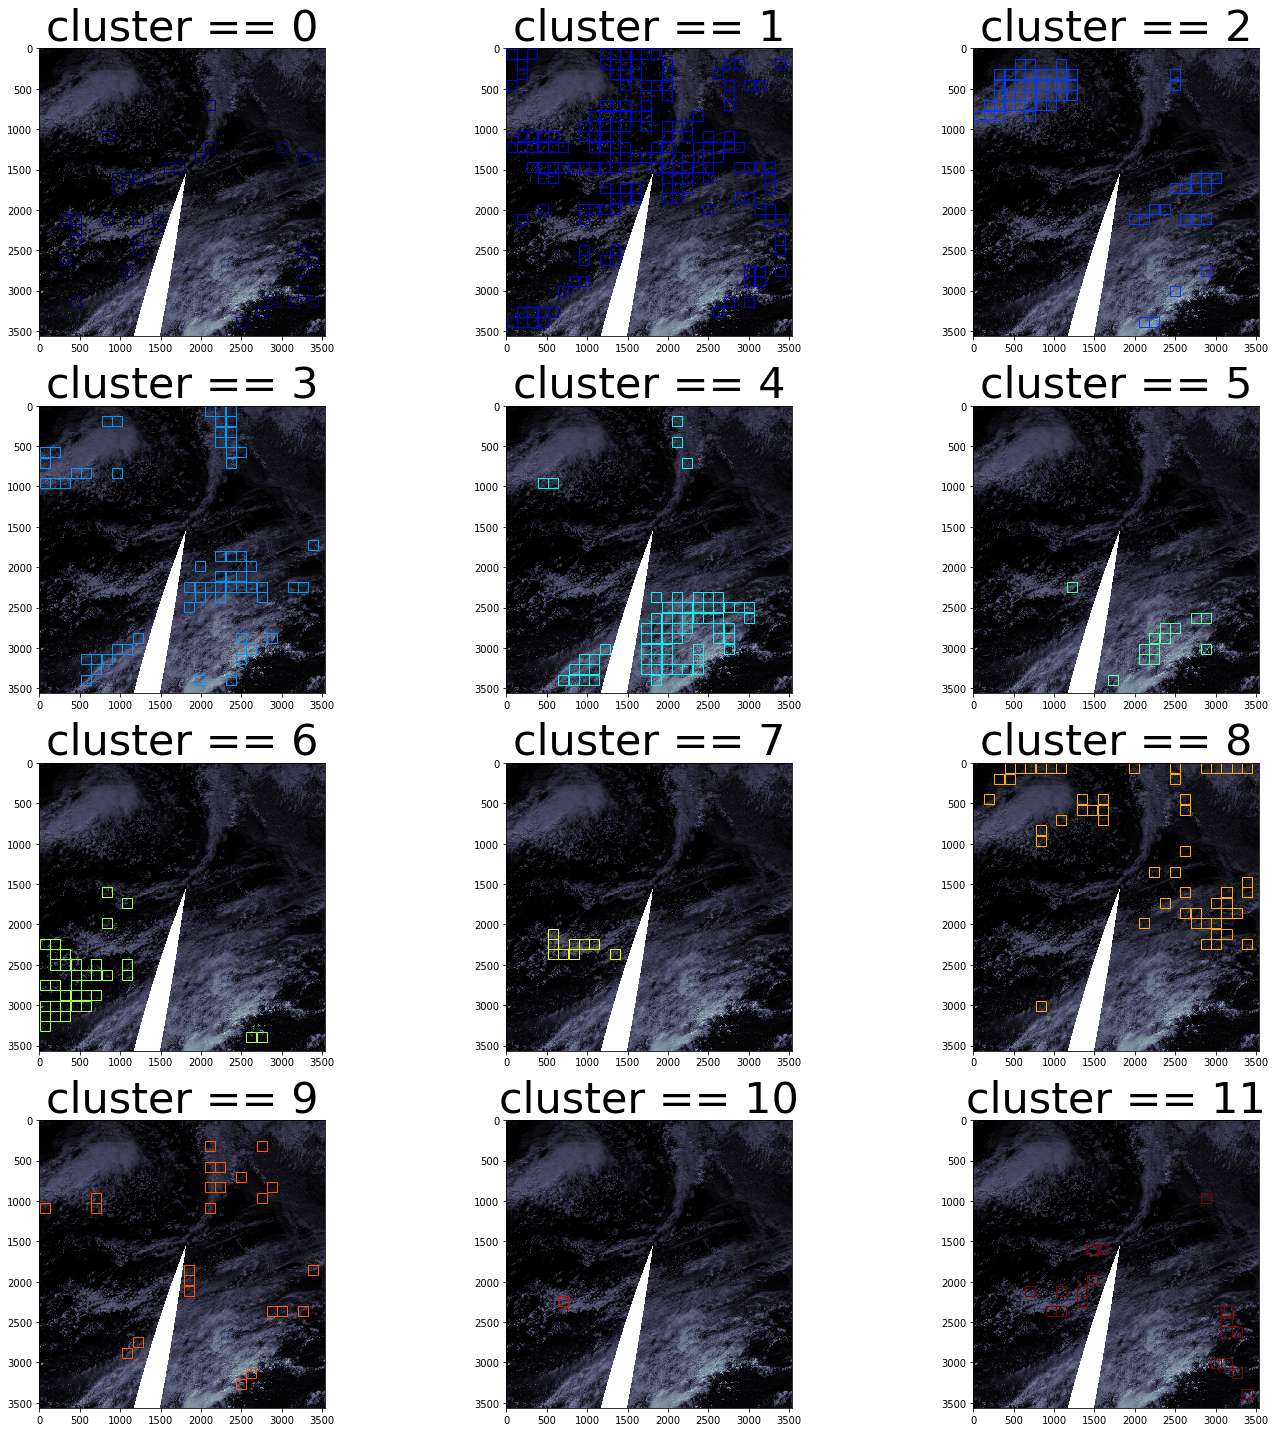

In [51]:
#Plot location of cluster patches on top of visual band image
fig = plt.figure(figsize=(20,20))

line_width = 2
SHAPE = 128,128
colors = _get_colors(n=n_clusters)
for idx, icluster in enumerate(range(n_clusters)):
    ax = plt.subplot(4,3,idx+1)
    plt.imshow(vhdf_array, cmap='bone')
    ax.set_title("cluster == %d"%(icluster), fontsize=43)
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            #==============================================
            if not np.isnan(cimg_array[i,j]):
                if cimg_array[i,j] == icluster:
                    #======================================
                    ax.add_patch(mpl_patches.Rectangle(
                      (j * SHAPE[0] + line_width , i * SHAPE[1] + line_width ),
                      width=SHAPE[0] - line_width * 2,
                      height=SHAPE[1] - line_width * 2,
                      linewidth=1,
                      edgecolor=colors[int(cimg_array[i,j])],
                      facecolor="none"                 
                      ))
fig.tight_layout()
plt.show()
#plt.savefig("Visual_clusters_12clusters_Cluster2")
plt.close()

### Automate entire process

In [62]:
def date_getter(name):
    bname = os.path.basename(name)
    dateinfo = re.findall('[0-9]{7}' , bname)
    date     = dateinfo[0].rstrip("['").lstrip("']")
    return date

In [63]:
nx, ny = 35, 37
n_clusters = 12

In [64]:
npyfile = os.path.join(anl_dir, 'aggl_p-18.0_nc-12_m02_b28_29_31_patches_labels_2000-2018_random_aggl.npy')
clouds_patches_labels_all = np.load(npyfile)

In [65]:
mod02_datadir = '/home/tkurihana/Research/data/MOD02/20151116-20151215'

In [66]:
datelist = [ date_getter(i) for i in npz_filelist]

In [70]:
cpatch = 0
ppatch = 0
for inpz, inpz_filelist in enumerate(npz_filelist):
    # initialize
    patches = np.ones((nx, ny)) * 12 # ncluster = 12
    
    # fileload --> get patch labels
    clouds_xy_list = npz_loader(inpz_filelist)
    cpatch += len(clouds_xy_list)
    clouds_patches_labels = clouds_patches_labels_all[ppatch:cpatch]
    cimg_array = reconst_img(patches,clouds_patches_labels,clouds_xy_list)
    ppatch = cpatch
    
    # 
    idate = datelist[inpz]
    #Access visual data
    vis_file =  glob.glob(os.path.join(mod02_datadir,'*'+idate+'*.EV_250_Aggr1km_RefSB_1.hdf'))[0]
    vhdf = SD(vis_file, SDC.READ)
    vhdf_sds = vhdf.select("EV_250_Aggr1km_RefSB")
    vhdf_array, vis_band = proc_sds(vhdf_sds)
    
    #Plot location of cluster patches on top of visual band image
    fig = plt.figure(figsize=(20,20))

    line_width = 2
    SHAPE = 128,128
    colors = _get_colors(n=n_clusters)
    for idx, icluster in enumerate(range(n_clusters)):
        ax = plt.subplot(4,3,idx+1)
        plt.imshow(vhdf_array, cmap='bone')
        ax.set_title("cluster == %d"%(icluster), fontsize=43)
        for i in range(patches.shape[0]):
            for j in range(patches.shape[1]):
                #==============================================
                if not np.isnan(cimg_array[i,j]):
                    if cimg_array[i,j] == icluster:
                        #======================================
                        ax.add_patch(mpl_patches.Rectangle(
                          (j * SHAPE[0] + line_width , i * SHAPE[1] + line_width ),
                          width=SHAPE[0] - line_width * 2,
                          height=SHAPE[1] - line_width * 2,
                          linewidth=1,
                          edgecolor=colors[int(cimg_array[i,j])],
                          facecolor="none"                 
                          ))
    fig.tight_layout()
    #plt.show()
    plt.savefig(os.path.join('figs' "visual_aggl_"+str(idate)+"_"+str(n_clusters)+"clusters_californica.png"))
    plt.close()

/home/tkurihana/Research/clouds/clustering/outputs/output_clouds_feature_20151116-20151215/clouds_patches_2015334.mosa_4.npz
Process bands 1


/home/tkurihana/Research/clouds/src_analysis/lib_hdfs/lib_modis02.py:92: RuntimeWarning: invalid value encountered in greater
  invalid_idx = np.where( array > 32767 )


/home/tkurihana/Research/clouds/clustering/outputs/output_clouds_feature_20151116-20151215/clouds_patches_2015344.mosa_4.npz
Process bands 1
/home/tkurihana/Research/clouds/clustering/outputs/output_clouds_feature_20151116-20151215/clouds_patches_2015348.mosa_3.npz
Process bands 1
/home/tkurihana/Research/clouds/clustering/outputs/output_clouds_feature_20151116-20151215/clouds_patches_2015342.mosa_2.npz
Process bands 1
/home/tkurihana/Research/clouds/clustering/outputs/output_clouds_feature_20151116-20151215/clouds_patches_2015336.mosa_1.npz
Process bands 1
/home/tkurihana/Research/clouds/clustering/outputs/output_clouds_feature_20151116-20151215/clouds_patches_2015320.mosa_0.npz
Process bands 1
/home/tkurihana/Research/clouds/clustering/outputs/output_clouds_feature_20151116-20151215/clouds_patches_2015339.mosa_4.npz
Process bands 1
/home/tkurihana/Research/clouds/clustering/outputs/output_clouds_feature_20151116-20151215/clouds_patches_2015335.mosa_0.npz
Process bands 1
/home/tkuriha

-------
### tSNE

In [71]:
patches_list = []
for ifile in npz_filelist:
    tmp_array = np.load(ifile)
    patches_list.extend(tmp_array['encs_mean'])

In [73]:
patches_array = np.concatenate([np.expand_dims(i, axis=0) for i in patches_list], axis=0)

In [74]:
patches_array.shape

(16610, 128)

In [78]:
def compute_tsne(data, ndim=2,nperplex=15):
    tsne = TSNEs(n_components=ndim, perplexity=nperplex)
    features = tsne.fit_transform(data)
    return features 

In [94]:
features_2d = compute_tsne(patches_array, ndim=2, nperplex=35)

Perplex == 5

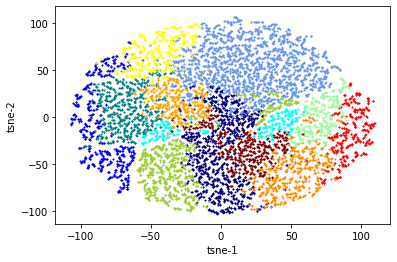

In [93]:
fig = plt.figure()
labels = clouds_patches_labels_all
colors =['navy','cornflowerblue','blue','teal',
         'aqua','palegreen', 'yellowgreen', 'darkorange',
         'yellow','orange','red','maroon'] 
for i in range(12):
    idx = np.where(labels == i)
    plt.scatter(features_2d[idx,0], features_2d[idx,1], s=0.5, color=colors[i])
plt.xlabel('tsne-1')
plt.ylabel('tsne-2')
plt.show()

Perplex == 15

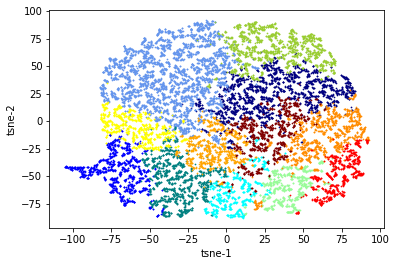

In [87]:
fig = plt.figure()
labels = clouds_patches_labels_all
colors =['navy','cornflowerblue','blue','teal',
         'aqua','palegreen', 'yellowgreen', 'darkorange',
         'yellow','orange','red','maroon'] 
for i in range(12):
    idx = np.where(labels == i)
    plt.scatter(features_2d[idx,0], features_2d[idx,1], s=0.5, color=colors[i])
plt.xlabel('tsne-1')
plt.ylabel('tsne-2')
plt.show()

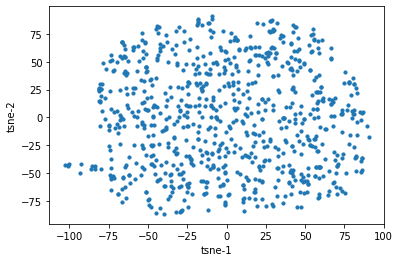

In [91]:
fig = plt.figure()
dx = np.random.randint(0,len(patches_array), int(len(patches_array)/20))
plt.scatter(features_2d[dx,0], features_2d[dx,1], s=10)
plt.xlabel('tsne-1')
plt.ylabel('tsne-2')
plt.show()

Perplex == 35

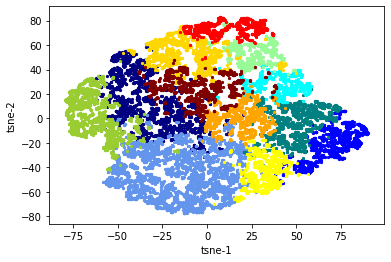

In [98]:
fig = plt.figure()
labels = clouds_patches_labels_all
colors =['navy','cornflowerblue','blue','teal',
         'aqua','palegreen', 'yellowgreen', 'gold',
         'yellow','orange','red','maroon'] 
for i in range(12):
    idx = np.where(labels == i)
    plt.scatter(features_2d[idx,0], features_2d[idx,1], s=5, color=colors[i])
plt.xlabel('tsne-1')
plt.ylabel('tsne-2')
plt.show()

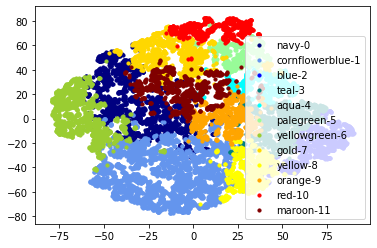

In [108]:
colors =['navy','cornflowerblue','blue','teal',
         'aqua','palegreen', 'yellowgreen', 'gold',
         'yellow','orange','red','maroon'] 
for i in range(12):
    idx = np.where(labels == i)
    plt.scatter(features_2d[idx,0], features_2d[idx,1], s=10, 
                color=colors[i], label='{}-{}'.format(colors[i], i))
plt.legend()

### Dendorogram for same dataset

In [109]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [111]:
Z = linkage(patches_array,method="ward",metric="euclidean")

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [45.0, 45.0, 55.0, 55.0],
  [35.0, 35.0, 50.0, 50.0],
  [25.0, 25.0, 42.5, 42.5],
  [10.0, 10.0, 33.75, 33.75],
  [75.0, 75.0, 85.0, 85.0],
  [65.0, 65.0, 80.0, 80.0],
  [105.0, 105.0, 115.0, 115.0],
  [95.0, 95.0, 110.0, 110.0],
  [125.0, 125.0, 135.0, 135.0],
  [102.5, 102.5, 130.0, 130.0],
  [72.5, 72.5, 116.25, 116.25],
  [21.875, 21.875, 94.375, 94.375],
  [145.0, 145.0, 155.0, 155.0],
  [175.0, 175.0, 185.0, 185.0],
  [165.0, 165.0, 180.0, 180.0],
  [150.0, 150.0, 172.5, 172.5],
  [195.0, 195.0, 205.0, 205.0],
  [225.0, 225.0, 235.0, 235.0],
  [215.0, 215.0, 230.0, 230.0],
  [200.0, 200.0, 222.5, 222.5],
  [161.25, 161.25, 211.25, 211.25],
  [265.0, 265.0, 275.0, 275.0],
  [255.0, 255.0, 270.0, 270.0],
  [245.0, 245.0, 262.5, 262.5],
  [285.0, 285.0, 295.0, 295.0],
  [315.0, 315.0, 325.0, 325.0],
  [335.0, 335.0, 345.0, 345.0],
  [320.0, 320.0, 340.0, 340.0],
  [305.0, 305.0, 330.0, 330.0],
  [290.0, 290.0, 317.5, 317.5],
  [253.75, 253.75, 3

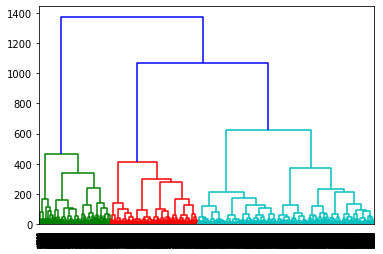

In [112]:
dendrogram(Z)